# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [1]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2021-03-26 16:48:16--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.112.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.112.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  11.7MB/s    in 0.9s    

2021-03-26 16:48:18 (11.7 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

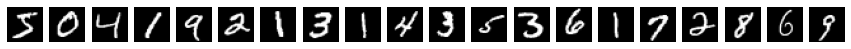

In [4]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [5]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [6]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def predict(weights, X):
    return np.array(list(map(softmax, np.dot(X, weights))))

def compute_loss_and_gradients(weights, X, y, l2_reg):
    n = X.shape[0]
    h = predict(weights, X)

    loss = -np.sum(y * np.log(h))/n + l2_reg * np.sum(weights * weights)
    grad = -np.dot(X.T, y - h)/n + l2_reg * weights
    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

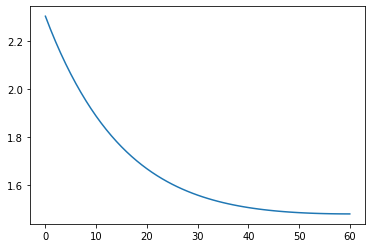

In [7]:
l2_reg = 0.15
n_epochs = 250
lr = 0.05

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)

    # early stopping
    if (loss > losses[-1] if len(losses) > 0 else False):
      break

    losses.append(loss)

    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [8]:
def accuracy(p, y):
  return 100*np.count_nonzero(np.argmax(p, axis=1) == np.argmax(y, axis=1))/y.shape[0]

print("Accuracy on training set: ", accuracy(predict(weights, x_train), y_train))
print("Accuracy on test set: ", accuracy(predict(weights, x_test), y_test))

Accuracy on training set:  81.01666666666667
Accuracy on test set:  81.53


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

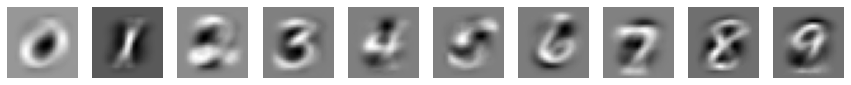

In [9]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [18]:
class MulticlassLogisticRegression():
  def _softmax(self, z):
    return np.exp(z)/np.sum(np.exp(z))
  
  def _h(self, X, theta):
    return np.array(list(map(softmax, np.dot(X, theta))))

  def fit(self, X, y, n_epochs=100, lr=0.05, l2_reg=0.15, early_stopping=True):
    theta = np.zeros([X.shape[1], y.shape[1]])
    n = X.shape[0]

    losses = []

    for i in range(n_epochs):
      theta = theta - lr*(-1./n*np.dot(X.T, y - self._h(X, theta)) + l2_reg * theta)
      losses.append(-np.sum(y * np.log(self._h(X, theta)))/n + l2_reg * np.sum(theta * theta))

      if early_stopping and len(losses) > 1 and losses[-2] < losses[-1]:
        break

    self._theta = theta
    return losses

  def predict(self, X):
    return self._h(X, self._theta)

In [19]:
reg = MulticlassLogisticRegression()
reg.fit(X, y)

[2.2480392229932438,
 2.1970437361728887,
 2.1492376265438513,
 2.1043555763574693,
 2.0621898171063062,
 2.0225682030020957,
 1.9853413316107902,
 1.950374893900618,
 1.9175451162285522,
 1.8867360530770232,
 1.8578379915217396,
 1.8307465205967803,
 1.8053619933778433,
 1.7815892158341338,
 1.7593372617314278,
 1.7385193530759726,
 1.7190527703646072,
 1.7008587721271637,
 1.6838625125485718,
 1.6679929515964182,
 1.6531827554540834,
 1.6393681870352315,
 1.6264889874668327,
 1.614488250005078,
 1.603312288096387,
 1.592910499342139,
 1.5832352270516996,
 1.5742416209254317,
 1.5658874982311017,
 1.5581332066450668,
 1.550941489737794,
 1.5442773559004566,
 1.5381079513407887,
 1.5324024376248757,
 1.527131874108247,
 1.5222691054844801,
 1.5177886545817563,
 1.5136666204561537,
 1.5098805817634777,
 1.5064095053373985,
 1.5032336598590692,
 1.5003345344706007,
 1.4976947621603278,
 1.4952980477304258,
 1.4931291001458806,
 1.4911735690570853,
 1.4894179852854865,
 1.487849705061984,

In [20]:
p = reg.predict(x_test)
print(accuracy(p, y_test))

# TODO cross validation + batch sizes(?)

81.53
